# Testing de paquetes para WebScrapping
Crear un venv para entorno de testing, fijaremos las dependencias en un requirements.txt cuando codifiquemos bien. 
Si falta paquete instalar con pip y **reiniciar el kernel**

In [3]:
import requests as req # No hace falta poner un alias, es por escribir menos

# Página objetivo, a poder ser sacar de la BBDD en un bucle
url = "https://www.pccomponentes.com/gigabyte-geforce-rtx-3060-windforce-oc-12gb-gddr6-rev-2"

# Requests realiza una llamada HTTP GET de forma automatizada con .get del paquete raiz
pagina = req.get(url)

print(pagina.status_code)

403


El objeto "página" es un Response, la respuesta de la petición HTTP GET.

Tiene muchos datos, como el código de respuesta, pero nos interesa el body o cuerpo en HTML de la página para el scrapping.

De todas formar conviene mirar el código de respuesta para comprobar si hemos conseguido el HTML con exito, en este caso da 403 que se traduce en Access Forbidden.

He probado con Postman (un simulador de requests HTTP) dado a que devuelve más info de la respuesta y me devuelve un 200 (Sucessfull), según GPT es porque Postman simula headers (metadatos) de navegador y seguramente PcComponentes rechaza peticiones que no sean de navegador. Vamos a probar añadiendo esos metadatos.

Para un listado de códigos HTTP mirar estos docs de Mozilla https://developer.mozilla.org/en-US/docs/Web/HTTP/Reference/Status

P.D. En los notebooks los valores de variables se mantienen, aun en la siguiente celda ya tenemos url y página cargadas en memoria como variables, no las voy a repetir

In [4]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36"
}

pagina = req.get(url, headers=headers)

print(pagina.status_code)

# Miramos primeros 500 caracteres del HTML si hay
print(pagina.text[:500])

403
<!DOCTYPE html><html lang="en-US"><head><title>Just a moment...</title><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"><meta http-equiv="X-UA-Compatible" content="IE=Edge"><meta name="robots" content="noindex,nofollow"><meta name="viewport" content="width=device-width,initial-scale=1"><style>*{box-sizing:border-box;margin:0;padding:0}html{line-height:1.15;-webkit-text-size-adjust:100%;color:#313131;font-family:system-ui,-apple-system,BlinkMacSystemFont,"Segoe UI",Roboto,"Helve


Voy a tirar mucho de GPT para esto.

Pasandole el HTML parece ser que nos quedamos atascados en la protección de CloudFlare porque requests no ejecuta código JavaScript que si que ejecutaria un navegador cliente.
Me sugiere usar cloudscraper, otro paquete. Vamos a probar

In [ ]:
import cloudscraper

url = "https://www.pccomponentes.com/gigabyte-geforce-rtx-3060-windforce-oc-12gb-gddr6-rev-2"

# Parece que cloudscraper nos obliga a crear el objeto scraper para usar la funcion .get, sintacticamente es requests con un paso mas
scraper = cloudscraper.create_scraper()

# Vamos a llamarle res de respuesta al objeto, por diferenciar de la pagina anterior que no nos sirve
res = scraper.get(url)

print(res.status_code)
print(res.text[:500])

200
<!DOCTYPE html>
<html lang="es-ES">

<head>
  <meta charset="UTF-8" />
  <meta name="viewport" content="width=device-width, initial-scale=1.0" />
  <meta http-equiv="X-UA-Compatible" content="ie=edge" />
  <meta name="apple-mobile-web-app-capable" content="yes" />
  <meta name="apple-mobile-web-app-status-bar-style" content="white" />

  <link rel="preload" href="https://fonts.gstatic.com/s/opensans/v43/memvYaGs126MiZpBA-UvWbX2vVnXBbObj2OVTS-muw.woff2"
    type="font/woff2" as="font" crossorigin


Perfecto, puede que con requests no podamos conseguir el HTML, pero con cloudscraper si. Vamos ahora con BeautifulSoup del paquete bs4, que nos permite navegar un HTML

In [7]:
from bs4 import BeautifulSoup

# Pasamos el texto plano a formato HTML con una funcion de Python (html.parser) para que BeautifulSoup pueda hacer sus cosas
soup = BeautifulSoup(res.text, 'html.parser')

# El comando prettify ordena visualmente el HTML para verlo estructurado e indentado. Esto es para el humano, al ordenador le da igual que este todo mezclado
print(soup.prettify())

<!DOCTYPE html>
<html lang="es-ES">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
  <meta content="ie=edge" http-equiv="X-UA-Compatible"/>
  <meta content="yes" name="apple-mobile-web-app-capable"/>
  <meta content="white" name="apple-mobile-web-app-status-bar-style"/>
  <link as="font" crossorigin="" href="https://fonts.gstatic.com/s/opensans/v43/memvYaGs126MiZpBA-UvWbX2vVnXBbObj2OVTS-muw.woff2" rel="preload" type="font/woff2"/>
  <meta content="https://www.pccomponentes.com/browserconfig.xml" name="msapplication-config"/>
  <link href="https://fonts.googleapis.com" rel="preconnect"/>
  <link href="https://fonts.googleapis.com" rel="dns-prefetch"/>
  <link href="https://fonts.gstatic.com" rel="preconnect"/>
  <link href="https://fonts.gstatic.com" rel="dns-prefetch"/>
  <link href="https://cdn.pccomponentes.com" rel="preconnect"/>
  <link href="https://cdn.pccomponentes.com" rel="dns-prefetch"/>
  <link href="https://thumb.

Ahora podemos buscar los campos que nos interesen. Vamos a la página en nuestro navegador y activamos las DevTools con F12:
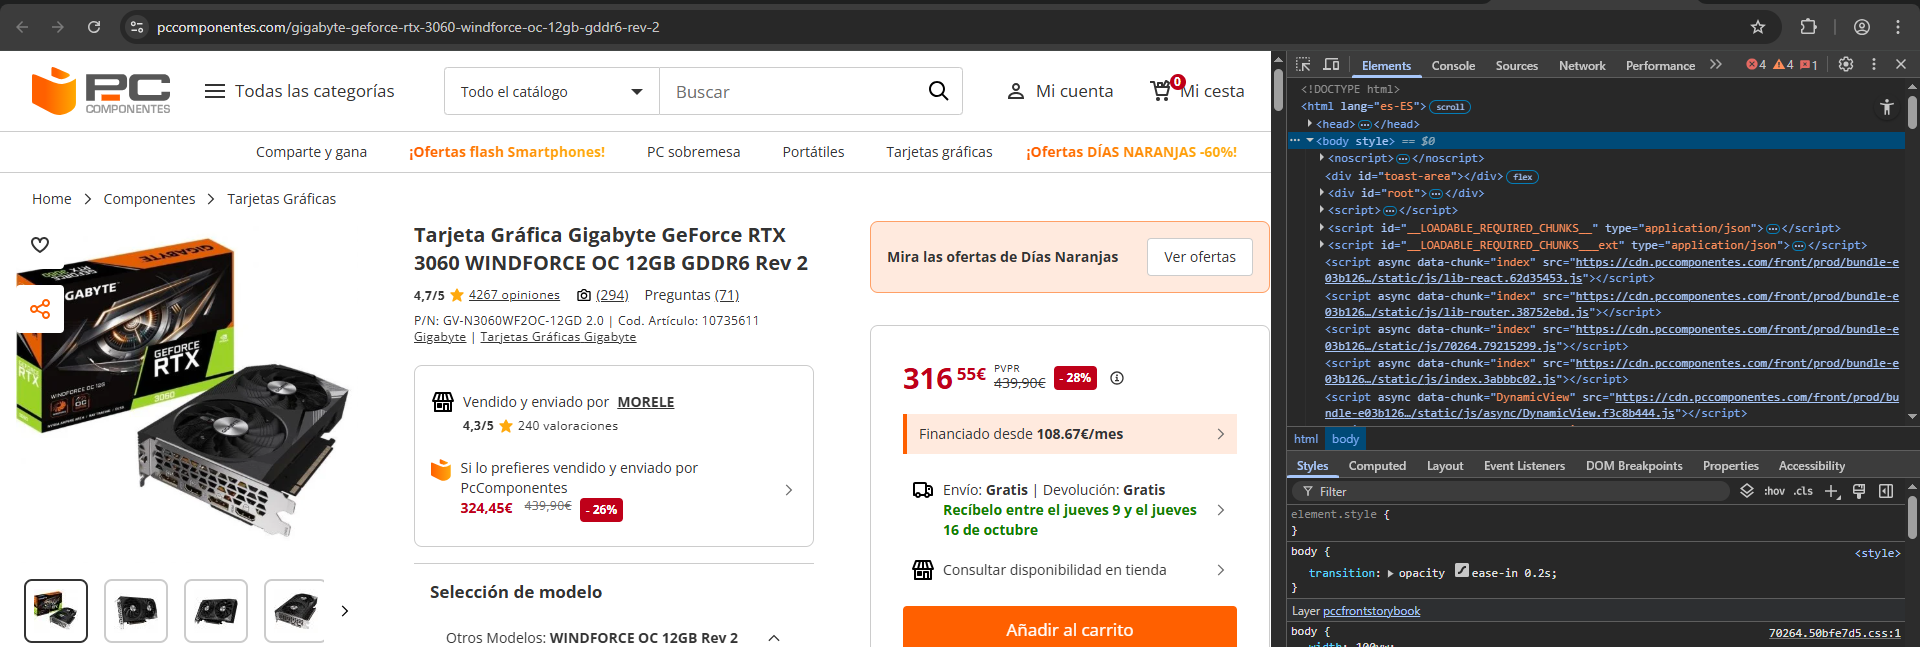

En la barra con elements, console, etc. ; al lado del icono de la tablet, está el selector de elementos. Le damos y cuando el ratón empieze a colorear trozos de la página le damos al precio:
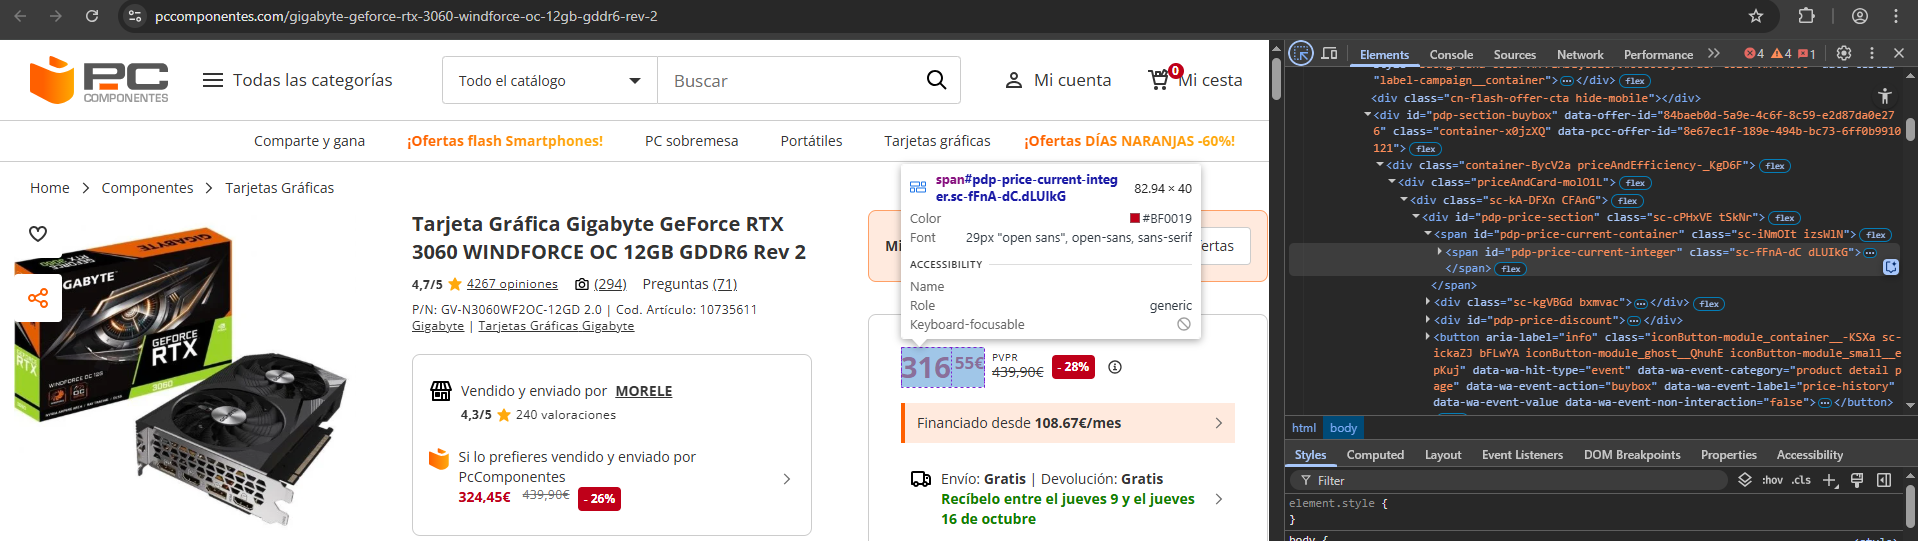

Parece que en PcComponentes dividen el precio entre parte entera y decimal según el HTML. Pero son muy majos y si nos fijamos el span tiene un id llamado "pdp-price-current-integer" y "pdp-price-current-decimal". El id por reglas de HTML es único, asi que tenemos un filtro cómodo y fácil.

In [8]:
soup.find_all(id='pdp-price-current-integer')

[<span class="sc-loyRtV fouHjd" id="pdp-price-current-integer">316<span class="sc-loIdfG bISpEj" id="pdp-price-current-decimals"><span class="sc-jUzWen itNPhm">,</span>55<!-- -->â¬</span></span>,
 <span class="sc-loyRtV fouHjd" id="pdp-price-current-integer">316<span class="sc-loIdfG bISpEj" id="pdp-price-current-decimals"><span class="sc-jUzWen itNPhm">,</span>55<!-- -->â¬</span></span>]

Ni idea de porque devuelve el objeto por duplicado cuando el id debería de ser único. Parece ser el mismo pero habría que hacer pruebas.

Lo bueno es que al parecer por hacer pequeña la parte decimal, el span de decimales va dentro del de integers, asi que de una busqueda tenemos el precio completo.

Ahora toca limpiar.

In [9]:
# Me lo guardo en una variable para hacer cosas luego
span_precio = soup.find_all(id='pdp-price-current-integer')

# Esto es un "sacame lo de dentro"
print(span_precio.text)

AttributeError: ResultSet object has no attribute "text". You're probably treating a list of elements like a single element. Did you call find_all() when you meant to call find()?

Fallo mio, find_all devuelve una lista de resultados (ResultSet), me basta con el primero, asi que uso find y ya.

In [10]:
span_precio = soup.find(id='pdp-price-current-integer')

# Esto es un "sacame lo de dentro"
print(span_precio.text)

316,55â¬


No me esperaba que sacase el texto recursivo, pero nos viene bien. Nos fusiona por su cuenta el precio, perfecto.

Vamos a eliminar eso del final que no nos sirve. Para ello vamos a usar Regex, que es un filtro de caracteres basicamente.

In [ ]:
import re

precio = soup.find(id='pdp-price-current-integer')

# Machaco la variable, no necesito el sucio para nada
# El Regex es "elige todo lo que no sea un numero del 0 al 9 o la coma" y sub sustituye con "" (que significa nada) para eliminar
precio = re.sub(r"[^0-9,]", "", precio)

print(precio)

TypeError: expected string or bytes-like object, got 'Tag'

Ups, parece que sigue siendo un objeto de BeautifulSoup llamado "Tag", hay un metodo para Tag -> String, vamos a usar eso

In [12]:
import re

precio = soup.find(id='pdp-price-current-integer')

# El .text saca String de Tag, tan simple como eso
precio = re.sub(r"[^0-9,]", "", precio.text)

print(precio)

316,55


Bam, tenemos el precio. Ahora lo guardamos donde sea con la hora actual o a saber. Vamos a hacer un miniciclo para ver la potencia de automatizar esto.

In [13]:
url1 = "https://www.pccomponentes.com/gigabyte-geforce-rtx-3060-windforce-oc-12gb-gddr6-rev-2"
url2 = "https://www.pccomponentes.com/tarjeta-grafica-msi-geforce-rtx-5060-gaming-oc-8gb-gddr7-reflex-2-rtx-ai-dlss4"
url3 = "https://www.pccomponentes.com/tarjeta-grafica-asus-tuf-gaming-amd-radeon-rx-9060-xt-oc-16gb-gddr6-fsr-4"

# Me las guardo en una lista para hacer el bucle
urls = [url1, url2, url3]

for url in urls:
    res = scraper.get(url) # El scraper estaba creado ya, pero sino crear de nuevo y ya
    soup = BeautifulSoup(res.text, 'html.parser')
    precio = soup.find(id='pdp-price-current-integer')
    precio = re.sub(r"[^0-9,]", "", precio.text)
    producto = url.split(".com/")[1] # Aprovechamos que el nombre del producto viene en la url tras el .com

    print(f"Producto: {producto}, Precio: {precio}") # Con fStrings podemos hacer plantilla de donde poner cada variable
    

Producto: gigabyte-geforce-rtx-3060-windforce-oc-12gb-gddr6-rev-2, Precio: 316,55
Producto: tarjeta-grafica-msi-geforce-rtx-5060-gaming-oc-8gb-gddr7-reflex-2-rtx-ai-dlss4, Precio: 374,90
Producto: tarjeta-grafica-asus-tuf-gaming-amd-radeon-rx-9060-xt-oc-16gb-gddr6-fsr-4, Precio: 485,42
